In [1]:
import tensorflow as tf
import numpy as np
import gym
import datetime
from tqdm import tqdm_notebook
import logging
import random
import itertools
from go_ai import go_utils, rl_utils
import matplotlib.pyplot as plt
import collections
from functools import reduce
import mcts

In [2]:
logger = logging.getLogger()
logger.setLevel(logging.INFO)

# Hyperparameters

In [3]:
BOARD_SIZE = 5

In [4]:
ITERATIONS = 256
EPISODES_PER_ITERATION = 64
MAX_STEPS = 2 * BOARD_SIZE**2
BATCH_SIZE = 64

In [5]:
LEARNING_RATE = 1e-2
BETA_1 = 0.9

In [6]:
SAVE_EVERY_ITERATION = True
LOAD_SAVED_MODELS = False
BASELINE_DIR = 'model_baselines/'
LEVEL_PATHS = [None]

In [7]:
EXPLORE_WEIGHT = 0.1
EXPLORE_DECAY = 0.9
MIN_EXPLORE = 0.1
CRITIC_GAMMA = 1/2

# Go Environment
Train on a small board with heuristic reward for fast training and efficient debugging

In [8]:
go_env = gym.make('gym_go:go-v0', size=BOARD_SIZE, reward_method='heuristic')

# Machine Learning Models

In [9]:
ACTOR_CRITIC_PATH = 'tmp/actor_critic.h5'

In [10]:
actor_critic = rl_utils.make_actor_critic(BOARD_SIZE, 'val_net', 'tanh')

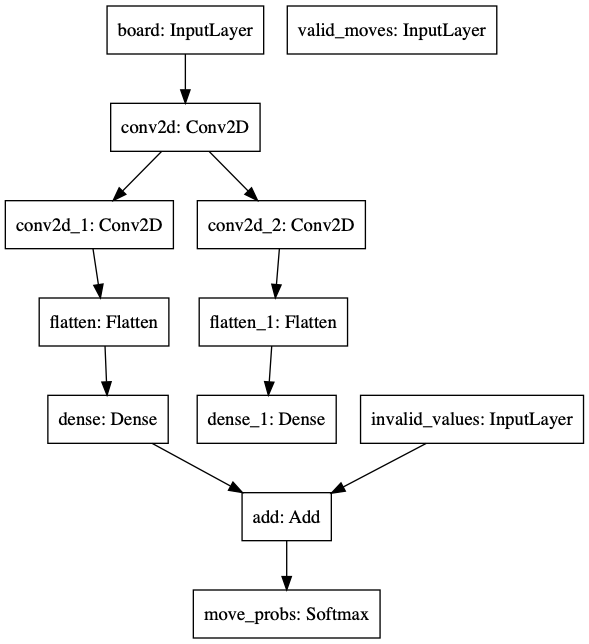

In [11]:
tf.keras.utils.plot_model(actor_critic)

In [12]:
actor_critic.summary()

Model: "actor_critic"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
board (InputLayer)              [(None, 5, 5, 6)]    0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 5, 5, 32)     1760        board[0][0]                      
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 5, 5, 2)      578         conv2d[0][0]                     
__________________________________________________________________________________________________
flatten (Flatten)               (None, 50)           0           conv2d_1[0][0]                   
_______________________________________________________________________________________

### Initialization of models 

In [16]:
mem = []
state = go_env.reset()
first_action = (2,3)
first_action_1d = go_utils.action_2d_to_1d(first_action, BOARD_SIZE)
second_action = (3,2)
first_state, reward, done, info = go_env.step(first_action)
second_state, reward, done, info = go_env.step(second_action)
rl_utils.add_to_replay_mem(mem, state, first_action_1d, second_state, reward, done, 0)

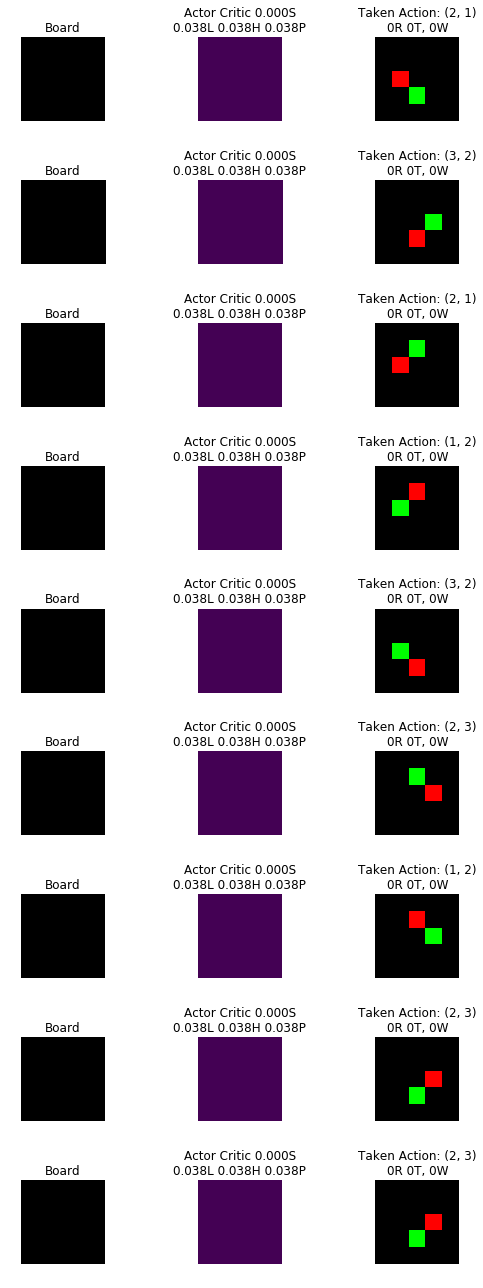

In [17]:
plt.show(rl_utils.sample_heatmaps(actor_critic, mem, num_samples=8))

# Training Setup

### Metrics and Tensorboard

In [18]:
!rm -rf ./logs/

Metrics

In [19]:
metrics = {}
for metric_key in ['val_loss', 'explore_loss', 'overall_loss', 'win_rate', 'num_steps', 'explore_weight']:
    metrics[metric_key] = tf.keras.metrics.Mean('{}'.format(metric_key), dtype=tf.float32)
metrics['pred_win_acc'] = tf.keras.metrics.Accuracy()

Tensorboard

In [20]:
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = 'logs/actor_critic/{}/main'.format(current_time)
summary_writer = tf.summary.create_file_writer(log_dir)    

### Helper Functions

In [21]:
binary_cross_entropy = tf.keras.losses.BinaryCrossentropy()

In [22]:
actor_critic_opt = tf.keras.optimizers.Adam(LEARNING_RATE, BETA_1)

In [42]:
def update_actor_critic(batched_mem, iteration, metrics):
    """
    Optimizes the actor over the whole replay memory
    """ 
    explore_weight = max(EXPLORE_WEIGHT * (EXPLORE_DECAY**iteration), MIN_EXPLORE)
    for states, actions, next_states, rewards, terminals, wins, mcts_action_probs in tqdm_notebook(batched_mem, 
                                                                                desc='Updating actor_critic', 
                                                                                leave=False):
        batch_size = states.shape[0]
        
        # Actor
        valid_moves = go_utils.get_valid_moves(states)
        
        # Critic
        next_move_probs, next_move_vals = rl_utils.forward_pass(next_states, actor_critic, training=True)
        targets = rewards + CRITIC_GAMMA * tf.math.reduce_sum(next_move_probs * next_move_vals, axis=1, keepdims=True)
        with tf.GradientTape() as tape:    
            move_prob_distrs, state_vals = rl_utils.forward_pass(states, actor_critic, training=True)
            
            # Actor
            explore_loss = tf.reduce_sum(mcts_action_probs * tf.math.log(move_prob_distrs), axis=1)
            explore_loss = tf.reduce_mean(explore_loss)
            
            # Critic
            assert state_vals.shape == wins.shape
            val_loss = tf.reduce_mean((wins - state_vals)**2)
            
            overall_loss = val_loss + move_loss
        
        metrics['explore_loss'].update_state(explore_loss)
        metrics['explore_weight'].update_state(explore_weight)
        
        metrics['val_loss'].update_state(val_loss)
        
        metrics['overall_loss'].update_state(overall_loss)
        
        wins_01 = np.copy(wins)
        wins_01[wins_01 < 0] = 0
        metrics['pred_win_acc'].update_state(wins_01, state_vals > 0)
        
        # compute and apply gradients
        gradients = tape.gradient(overall_loss, actor_critic.trainable_variables)
        actor_critic_opt.apply_gradients(zip(gradients, actor_critic.trainable_variables))

# Train

In [44]:
replay_mem = []

In [ ]:
for iteration in tqdm_notebook(range(ITERATIONS), desc='Iteration'):
    # Update other models if appropriate
    if SAVE_EVERY_ITERATION:
        logging.debug("Saving weights...")
        actor_critic.save_weights(ACTOR_CRITIC_PATH)

    # Train
    logging.debug("Playing games")
    episode_pbar = tqdm_notebook(range(EPISODES_PER_ITERATION), desc='Episode {}'.format(iteration), leave=False)
    for episode in episode_pbar:
        num_steps = rl_utils.play_a_game(replay_mem, go_env, policy=actor_critic, max_steps=MAX_STEPS)
        metrics['num_steps'].update_state(num_steps)

    # Update the models (also shuffles memory)
    logging.debug("Updating model...")
    random.shuffle(replay_mem)
    np_data = rl_utils.replay_mem_to_numpy(replay_mem)
    batched_np_data = [np.array_split(datum, len(replay_mem) // BATCH_SIZE) for datum in np_data]
    batched_mem = list(zip(*batched_np_data))
    update_actor_critic(batched_mem, iteration, metrics)
    
    # Evaluate against previous model
    rl_utils.evaluate(go_env, actor_critic, opponent, LEVEL_PATHS, MAX_STEPS)
    
    # Log results and resets the metrics
    logging.debug("Logging metrics to tensorboard...")
    rl_utils.log_to_tensorboard(summary_writer, metrics, iteration, replay_mem, actor_critic)

    # Reset memory
    replay_mem.clear()

# Evaluate

Evaluate against different levels of opponents

In [ ]:
rl_utils.evaluate(go_env, actor_critic, opponent, LEVEL_PATHS, MAX_STEPS)

Play against our AI

In [ ]:
go_env = gym.make('gym_go:go-v0', size=7)
rl_utils.play_against(actor_critic, go_env)